In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import geopandas
import pandas
import pathlib
import numpy
import matplotlib
import seaborn
import shapely
import rioxarray
import matplotlib.pyplot
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))

# Plan
* Load in GeoFabrics estimated width, depth and water surface height - (using those used in GeoFabrics - i.e. same level of smoothing)
  * Calculate channel area - assume rectangular
* Load in measured cross sections
  * Transform to NZVD2016
  * Calculate the channel area - use the same water height as the GeoFabrics estimates
* Compare the results
  * Take the nearest GeoFabrics cross section to each measured cross section
  * Plot area's on the same plot

In [2]:
resolution = 10
horizontal_crs = 2193

### Load in GeoFabrics Bathymetry estimates

In [106]:
cache_path = pathlib.Path(fr"C:\Users\pearsonra\Documents\data\Waikanae\caches\Wellington_2013\measured_river")
folder = "slope_0_002_min_width_50_mean"
dem_river_smart = rioxarray.rioxarray.open_rasterio(cache_path / folder / "dem_10m_all_rupp_and_smart.nc", masked=True).squeeze("band", drop=True)
dem_river_neal = rioxarray.rioxarray.open_rasterio(cache_path / folder / "dem_10m_all_neal_et_al.nc", masked=True).squeeze("band", drop=True)
dem_no_river = rioxarray.rioxarray.open_rasterio(cache_path / r"dem_10m_unconditioned_on_land.nc", masked=True).squeeze("band", drop=True)

In [107]:
river_centreline = geopandas.read_file(cache_path / r"aligned_river_centreline_100000000.geojson")
river_polygon = geopandas.read_file(cache_path / folder / "river_polygon.geojson")
fan_polygon = geopandas.read_file(cache_path / folder / "fan_polygon.geojson")

In [108]:
polygon = geopandas.GeoDataFrame( pandas.concat([river_polygon, fan_polygon], ignore_index=True), crs=river_polygon.crs).dissolve()

## Load in Measured cross sections
See raw cell below for converting to NZVD2016. This has already been done so load in the converted one directly

In [109]:
cross_section_elevation_label = 'Level'
cross_section_name_label = 'Section'
measured_sections = geopandas.read_file(r"C:/Users/pearsonra/Documents/data/river_bathemetry/sections/Waikanae/Waikanae_Cross_Sections_NIWA/2014_Survey_XS_NZVD2016.geojson")

In [110]:
measured_sections.head(2)

,Number,Source,Section,Offset,Northing,Easting,Level,Code,Date,Upstream,lvd_conversion,z_2016,geometry
0,10001.0,C,10.0,0.00,6035173.66,2679120.52,2.52,CP,20141022.0,0.0,0.356669,2.163331,POINT Z (1769102.282 5473458.894 2.163)
1,10002.0,F,10.0,0.09,6035173.75,2679120.55,2.59,SH,20141022.0,0.0,0.356669,2.233331,POINT Z (1769102.312 5473458.984 2.233)


### Simplify the measured points to min point/line strings

In [111]:
measured_centres = {'Section': [], 'geometry': []}
measured_lines = {'Section': [], 'geometry': [], 'min_elevation': []}
for section in measured_sections[cross_section_name_label].unique():
    measured_section = measured_sections[measured_sections[cross_section_name_label] == section]
    measured_centre = measured_section[measured_section[cross_section_elevation_label]==measured_section['Level'].min()].iloc[0]
    measured_centres['Section'].append(section)
    measured_centres['geometry'].append(measured_centre['geometry'])
    
    measured_lines['Section'].append(section)
    measured_lines['geometry'].append(shapely.geometry.LineString( [[measure_point.x, measure_point.y, measure_point.z] for measure_point in measured_section.geometry.values] ))
    measured_lines['min_elevation'].append(measured_section[cross_section_elevation_label].min())
measured_centres = geopandas.GeoDataFrame(measured_centres, crs=horizontal_crs)
measured_lines = geopandas.GeoDataFrame(measured_lines, crs=horizontal_crs)

## Sample DEM for elevations
Record the Bias and STDev for each cross section against the two DEMS

<AxesSubplot:>

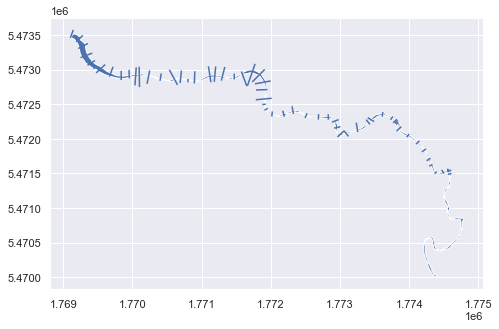

In [112]:
import matplotlib.pyplot
fig, ax = matplotlib.pyplot.subplots(ncols=1, nrows=1, figsize=(10, 5))
river_polygon.plot(ax=ax)
measured_lines.plot(ax=ax)

# Sample every 1m
Use Linear interpolation in between

In [113]:
comparisons_sampled = {"Unconditioned DEM z": [], "Conditioned neal DEM z": [], "Conditioned smart DEM z": [], "Measured Section z": [], "Section": [], "River": [], "Distance Upstream [m]": [], "Offset [m]": []}
for index, row in measured_lines.iterrows():
    print(f"Section number = {index}")
    line = row.geometry
    distance_upstream = float(river_centreline.project(measured_centres.iloc[index].geometry))
    for offset in list(range(int(numpy.ceil(line.length)))):
        point = line.interpolate(offset)
        comparisons_sampled["Unconditioned DEM z"].append(float(dem_no_river.z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Conditioned neal DEM z"].append(float(dem_river_neal.z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Conditioned smart DEM z"].append(float(dem_river_smart.z.interp(x=point.x, y=point.y)))
        comparisons_sampled["Measured Section z"].append(point.z)
        comparisons_sampled["Section"].append(row['Section'])
        comparisons_sampled["River"].append(polygon.iloc[0].geometry.contains(point))
        comparisons_sampled["Distance Upstream [m]"].append(distance_upstream)
        comparisons_sampled["Offset [m]"].append(offset)
        
comparisons_sampled = pandas.DataFrame.from_dict(comparisons_sampled)

Section number = 0
Section number = 1
Section number = 2
Section number = 3
Section number = 4
Section number = 5
Section number = 6
Section number = 7
Section number = 8
Section number = 9
Section number = 10
Section number = 11
Section number = 12
Section number = 13
Section number = 14
Section number = 15
Section number = 16
Section number = 17
Section number = 18
Section number = 19
Section number = 20
Section number = 21
Section number = 22
Section number = 23
Section number = 24
Section number = 25
Section number = 26
Section number = 27
Section number = 28
Section number = 29
Section number = 30
Section number = 31
Section number = 32
Section number = 33
Section number = 34
Section number = 35
Section number = 36
Section number = 37
Section number = 38
Section number = 39
Section number = 40
Section number = 41
Section number = 42
Section number = 43
Section number = 44
Section number = 45
Section number = 46
Section number = 47
Section number = 48
Section number = 49
Section nu

## Bed elevation errors
95% confidence interval plot for the errors along each section in the river

In [114]:
comparisons_sampled["Unconditioned DEM Elevation Errors"] = comparisons_sampled["Unconditioned DEM z"] - comparisons_sampled["Measured Section z"]
comparisons_sampled["Conditioned Neal DEM Elevation Errors"] = comparisons_sampled["Conditioned neal DEM z"] - comparisons_sampled["Measured Section z"]
comparisons_sampled["Conditioned Smart DEM Elevation Errors"] = comparisons_sampled["Conditioned smart DEM z"] - comparisons_sampled["Measured Section z"]

In [115]:
comparisons_sampled.head(1)

,Unconditioned DEM z,Conditioned neal DEM z,Conditioned smart DEM z,Measured Section z,Section,River,Distance Upstream [m],Offset [m],Unconditioned DEM Elevation Errors,Conditioned Neal DEM Elevation Errors,Conditioned Smart DEM Elevation Errors
0,1.924462,1.924462,1.924462,2.163331,10.0,False,0.0,0,-0.238869,-0.238869,-0.238869


In [116]:
comparisons_for_plotting=comparisons_sampled.rename(
    columns={"Unconditioned DEM Elevation Errors": "Unconditioned DEM", "Conditioned Neal DEM Elevation Errors": "Uniform Flow DEM", "Conditioned Smart DEM Elevation Errors": "Multivariate Regression DEM"}).drop(
    columns=["Unconditioned DEM z", "Conditioned neal DEM z", "Conditioned smart DEM z", "Measured Section z"]).melt(
    id_vars=["Section", "Distance Upstream [m]", "River", "Offset [m]"], var_name="Comparison", value_name="Riverbed Elevation Error [m]")

In [117]:
comparisons_for_plotting.head(1)

,Section,Distance Upstream [m],River,Offset [m],Comparison,Riverbed Elevation Error [m]
0,10.0,0.0,False,0,Unconditioned DEM,-0.238869


[Text(0.5, 1.0, 'Section Depths Comparison 95% CI')]

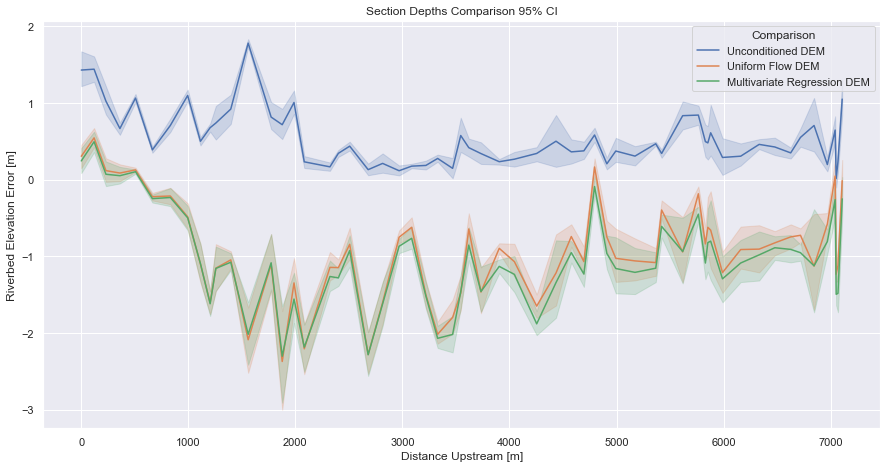

In [118]:
seaborn.set(rc={'figure.figsize':(15,7.5)})
seaborn.lineplot(data=comparisons_for_plotting[comparisons_for_plotting["River"]], x="Distance Upstream [m]", y="Riverbed Elevation Error [m]", hue="Comparison").set(title='Section Depths Comparison 95% CI')

In [119]:
summary = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=["Unconditioned DEM z", "Conditioned neal DEM z", "Conditioned smart DEM z", "Measured Section z", "River", "Section"]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
depth_summary = pandas.DataFrame([[summary.mean()["Unconditioned DEM Elevation Errors"], summary.mean()["Conditioned Neal DEM Elevation Errors"], summary.mean()["Conditioned Smart DEM Elevation Errors"]],
                                  [summary.std()["Unconditioned DEM Elevation Errors"], summary.std()["Conditioned Neal DEM Elevation Errors"], summary.std()["Conditioned Smart DEM Elevation Errors"]]],
                                  index = ["Mean Error", "Standard Deviation"], columns=["Unconditioned DEM", "Uniform Flow DEM", "Multivariate Regression DEM"])
depth_summary

,Unconditioned DEM,Uniform Flow DEM,Multivariate Regression DEM
Mean Error,0.616312,-0.625751,-0.724285
Standard Deviation,0.601401,0.890586,0.906760


# Channel Area error
The total area of the channel at each section

In [120]:
channel_depths = comparisons_sampled[comparisons_sampled['River']].drop(
    columns=["Unconditioned DEM Elevation Errors", "Conditioned Neal DEM Elevation Errors", "Conditioned Smart DEM Elevation Errors", "River", "Section"]).set_index(
    keys=["Distance Upstream [m]", "Offset [m]"])
section_max_evaluation = channel_depths.groupby("Distance Upstream [m]")[["Measured Section z"]].max()

In [121]:
channel_depths.head(1)

,,Unconditioned DEM z,Conditioned neal DEM z,Conditioned smart DEM z,Measured Section z
Distance Upstream [m],Offset [m],,,,
0.0,11,0.986275,0.760514,0.75193,0.246071


In [122]:
# Some hacky code to subtract the max elevation from each column in turn
channel_depths["Measured Section"] = section_max_evaluation - channel_depths[["Measured Section z"]]
channel_depths["Unconditioned DEM"] = section_max_evaluation.rename(columns={"Measured Section z": "Unconditioned DEM z"}) - channel_depths[["Unconditioned DEM z"]]
channel_depths["Uniform Flow DEM"] = section_max_evaluation.rename(columns={"Measured Section z": "Conditioned neal DEM z"}) - channel_depths[["Conditioned neal DEM z"]]
channel_depths["Multivariate Regression DEM"] = section_max_evaluation.rename(columns={"Measured Section z": "Conditioned smart DEM z"}) - channel_depths[["Conditioned smart DEM z"]]
channel_depths.head(1)

,,Unconditioned DEM z,Conditioned neal DEM z,Conditioned smart DEM z,Measured Section z,Measured Section,Unconditioned DEM,Uniform Flow DEM,Multivariate Regression DEM
Distance Upstream [m],Offset [m],,,,,,,,
0.0,11,0.986275,0.760514,0.75193,0.246071,0.504899,-0.235305,-0.009544,-0.00096


In [123]:
channel_area = channel_depths.drop(
    columns=["Measured Section z", "Unconditioned DEM z", "Conditioned neal DEM z", "Conditioned smart DEM z"]).groupby("Distance Upstream [m]").sum()
channel_area.head(1)

,Measured Section,Unconditioned DEM,Uniform Flow DEM,Multivariate Regression DEM
Distance Upstream [m],,,,
0.0,101.948749,3.346938,80.950768,85.09104


In [124]:
areas_for_plotting=channel_area.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Riverbed Area [m^2]")

[Text(0.5, 1.0, 'Channel Area Comparison')]

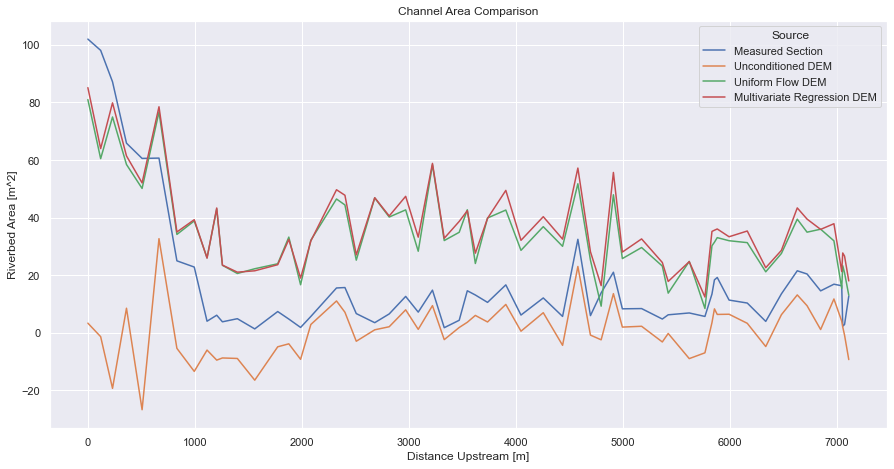

In [125]:
seaborn.set(rc={'figure.figsize':(15,7.5)})
seaborn.lineplot(data=areas_for_plotting, x="Distance Upstream [m]", y="Riverbed Area [m^2]", hue="Source").set(title='Channel Area Comparison')

In [126]:
unconditioned_error = channel_area["Unconditioned DEM"]-channel_area["Measured Section"]
conditioned_neal_error = channel_area["Uniform Flow DEM"]-channel_area["Measured Section"]
conditioned_smart_error = channel_area["Multivariate Regression DEM"]-channel_area["Measured Section"]

area_summary = pandas.DataFrame([[unconditioned_error.mean(), conditioned_neal_error.mean(), conditioned_smart_error.mean()], [unconditioned_error.std(), conditioned_neal_error.std(), conditioned_smart_error.std()]], 
                                index = ["Mean Error", "Standard Deviation"], columns=["Unconditioned DEM", "Uniform Flow DEM", "Multivariate Regression DEM"])
area_summary

,Unconditioned DEM,Uniform Flow DEM,Multivariate Regression DEM
Mean Error,-16.692662,16.948308,19.617079
Standard Deviation,23.910114,14.408610,13.832000


In [127]:
pandas.DataFrame([[summary.mean()["Unconditioned DEM Elevation Errors"], summary.mean()["Conditioned Neal DEM Elevation Errors"], summary.mean()["Conditioned Smart DEM Elevation Errors"]],
                  [summary.std()["Unconditioned DEM Elevation Errors"], summary.std()["Conditioned Neal DEM Elevation Errors"], summary.std()["Conditioned Smart DEM Elevation Errors"]],
                  [unconditioned_error.mean(), conditioned_neal_error.mean(), conditioned_smart_error.mean()], 
                  [unconditioned_error.std(), conditioned_neal_error.std(), conditioned_smart_error.std()]], 
                 index = [["Bed Elevations", "Bed Elevations", "Cross-sectional Areas", "Cross-sectional Areas"],
                          ["Mean Error [m]", "Standard Deviation", "Mean Error [m^2]", "Standard Deviation"]], 
                 columns=["Unconditioned DEM", "Uniform Flow DEM", "Multivariate Regression DEM"])

Unconditioned DEM  Uniform Flow DEM  \
Bed Elevations        Mean Error [m]               0.616312         -0.625751   
                      Standard Deviation           0.601401          0.890586   
Cross-sectional Areas Mean Error [m^2]           -16.692662         16.948308   
                      Standard Deviation          23.910114         14.408610   

                                          Multivariate Regression DEM  
Bed Elevations        Mean Error [m]                        -0.724285  
                      Standard Deviation                     0.906760  
Cross-sectional Areas Mean Error [m^2]                      19.617079  
                      Standard Deviation                    13.832000

# Plot difference in area plot

In [128]:
channel_area_difference = pandas.DataFrame()
channel_area_difference["Unconditioned DEM"] = channel_area["Unconditioned DEM"]-channel_area["Measured Section"]
channel_area_difference["Uniform Flow DEM"] = channel_area["Uniform Flow DEM"]-channel_area["Measured Section"]
channel_area_difference["Multivariate Regression DEM"] = channel_area["Multivariate Regression DEM"]-channel_area["Measured Section"]
channel_area_difference.head(1)

,Unconditioned DEM,Uniform Flow DEM,Multivariate Regression DEM
Distance Upstream [m],,,
0.0,-98.601811,-20.997981,-16.857709


In [129]:
area_diffs_for_plotting=channel_area_difference.reset_index().melt(id_vars=["Distance Upstream [m]"], var_name="Source", value_name="Cross-sectional Area [m^2]")
area_diffs_for_plotting.head(1)

,Distance Upstream [m],Source,Cross-sectional Area [m^2]
0,0.0,Unconditioned DEM,-98.601811


[Text(0.5, 1.0, 'Channel Area Error')]

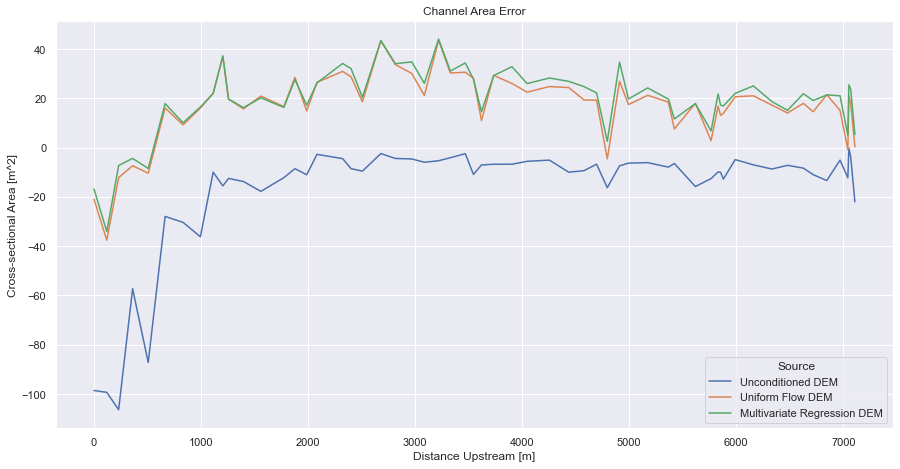

In [130]:
seaborn.set(rc={'figure.figsize':(15,7.5)})
seaborn.lineplot(data=area_diffs_for_plotting, x="Distance Upstream [m]", y="Cross-sectional Area [m^2]", hue="Source").set(title='Channel Area Error')